In [1]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

# Load water balance data 

In [2]:
# Load preprocessed RS Data (P, R, SM, SWE) generated with 02_P_ET_SM
rsdf = rs.col_to_dt(pd.read_csv("../data/wyandotte_RS_analysis_dat.csv"))
rsdf['Date'] = rsdf.index
rsdf['water_year'] = rsdf['Date'].dt.year.where(rsdf['Date'].dt.month < 10, rsdf['Date'].dt.year + 1)

rsdf_yearly = rsdf.groupby(pd.PeriodIndex(rsdf['water_year'], freq="Y")).sum()
rsdf = rsdf_yearly.iloc[1: , :]

# Inflow via streams, canals, aqueducts, etc 
q_in = rs.col_to_dt(pd.read_csv("../data/wyandotte_inflow.csv"))
q_in.columns = ['Inflow']
q_out = rs.col_to_dt(pd.read_csv("../data/wyandotte_outflow.csv"))
q_out.columns = ['Outflow']
q_in.index = q_in.index.to_period(freq='Y')
q_out.index = q_out.index.to_period(freq='Y')

#q_out = q_in
#q_out['Outflow'] = q_out['Inflow']
#print(q_out.info())

# Load ET data processed using crop coefficient method
modkc_et = rs.col_to_dt(pd.read_csv("../data/wyandotte_MODkc.csv"))
modkc_et.index = modkc_et.index + pd.offsets.MonthEnd(0)
modkc_et['Date'] = modkc_et.index

modkc_et['water_year'] = modkc_et['Date'].dt.year.where(modkc_et['Date'].dt.month < 10, modkc_et['Date'].dt.year + 1)
modkc_et = modkc_et.groupby(pd.PeriodIndex(modkc_et['water_year'], freq="Y")).sum()
modkc_et = modkc_et.iloc[1: , :]
# Load SSEBop ET data
ssebop_et =  rs.col_to_dt(pd.read_csv("../data/wyandotte_ssebop_et.csv"))
ssebop_et.index = ssebop_et.index + pd.offsets.MonthEnd(0)
ssebop_et['Date'] = ssebop_et.index
ssebop_et['water_year'] = ssebop_et['Date'].dt.year.where(ssebop_et['Date'].dt.month < 10, ssebop_et['Date'].dt.year + 1)
ssebop_et = ssebop_et.groupby(pd.PeriodIndex(ssebop_et['water_year'], freq="Y")).sum()
ssebop_et = ssebop_et.iloc[2: , :]
# Reservoir Data for CV and CVWS generated with 00_Q_Sres.py
#Sres = rs.col_to_dt(pd.read_csv('../data/res_stor_km3.csv'))
#Sres.columns = ['Sres_km3'] 
#Sres.index = Sres.index - pd.offsets.MonthEnd(0) 

# Merge dataframes (better way to do this?)
#tdf1 = pd.merge(rsdf,q_in,left_index = True, right_index = True)
#tdf1.info()
tdf1 = pd.merge(rsdf,q_in,left_index = True, right_index = True)
tdf2 = pd.merge(tdf1,q_out,left_index = True, right_index = True)
tdf3 = pd.merge(tdf2, modkc_et,left_index = True, right_index = True)
#tdf4 = pd.merge(tdf3, Sres,left_index = True, right_index = True)
wbdf = pd.merge(tdf3, ssebop_et,left_index = True, right_index = True)
wbdf.index = wbdf.index.to_timestamp()

In [3]:
wbdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2002-01-01 to 2021-01-01
Freq: AS-JAN
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p_prism       20 non-null     float64
 1   p_gpm         20 non-null     float64
 2   p_dmet        20 non-null     float64
 3   p_chirps      20 non-null     float64
 4   p_psn         20 non-null     float64
 5   aet_modis     20 non-null     float64
 6   aet_gldas     20 non-null     float64
 7   aet_tc        20 non-null     float64
 8   aet_fldas     20 non-null     float64
 9   pet_modis     20 non-null     float64
 10  pet_gldas     20 non-null     float64
 11  pet_tc        20 non-null     float64
 12  pet_nldas     20 non-null     float64
 13  pet_gmet      20 non-null     float64
 14  sm_smos       20 non-null     float64
 15  sm_smap       20 non-null     float64
 16  sm_tc         20 non-null     float64
 17  sm_gldas      20 non-null     float64
 18 

# Load Validation data

In [4]:
# C2vsim 
c2vsim = pd.read_csv("../data/c2vsim_ds_km3.csv")
c2vsim['Date'] = [x[:-6] for x in c2vsim['time'].values]
c2vsim['Date'] = pd.to_datetime(c2vsim['Date'])
c2vsim.index = c2vsim['Date']
c2vsim.drop(['Date','time'], axis = 1, inplace = True)

# Wells 
wells_ds = pd.read_csv('../data/wells_ds_ma8.csv')
wells_ds['dt'] = pd.to_datetime(wells_ds['year'])
wells_ds.set_index('dt', inplace = True)

In [5]:
####### TRIPLE COLLOCATION FUNCTIONS #######

def calc_tc_error(x,y,z):
    '''
    calculate errors between triplets
    '''
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    '''
    scale one dataset to another (mean / std)
    '''
    return ((src - np.nanmean(src)) / np.nanstd(src)) * np.nanstd(ref) + np.nanmean(ref)


def do_tc(df):
    '''
    wrapper for calc_tc_error applied to a df 
    '''
    tc_dict = df.astype(float).to_dict('list')
    combos=itertools.permutations(tc_dict, 3) 

    err_dict = {k:[] for k in tc_dict}

    for idx,i in enumerate(combos):

        x = tc_dict[i[0]]
        y = tc_dict[i[1]]
        z = tc_dict[i[2]]

        y_scaled = scale_to_ref(y,x)
        z_scaled = scale_to_ref(z,x)

        e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

        err_dict[i[0]].append(e_x)
        err_dict[i[1]].append(e_y)
        err_dict[i[2]].append(e_z)
        
    return err_dict
    

######## PLOTTING FUNCS #########
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')
    ydf.resample("Y").sum().boxplot(ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B') for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.style.use('default')
    plt.show()
    
def make_plots(df, coldict, var):
    '''
    for a dataframe of a single variable and a dict mapping col names to datasets, display:
    1) mean annual boxplot, 
    2) mean monthly scatterplot, 
    3) full timeseries, 
    4) correlation plot
    5) Triple collocation error box plot
    '''
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')

    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
        
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [datetime.date(1900, x, 1).strftime('%B')[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 3:4])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 4:5])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    # plt.tight_layout()
    plt.style.use('default')
    plt.show()

    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.38)
    # Time series
    ax5 = fig.add_subplot(gs[-1, :-1])
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.5),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)

    # plt.tight_layout()
    plt.style.use('default')
    plt.show()
    return ax1, ax2, ax3, ax4, ax5

    
def draw_poly(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True):
    
    '''
    Turns a geopandas gdf of polygons into matplotlib polygon patches for friendly plotting with basemap. 
    
    TODO: Add functionality for multipolys 
    '''
    
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill)
    plt.gca().add_patch(poly)


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 0.006
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor)

    
def align_yaxis(axes):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array(axes)
    extrema = np.array([ax.get_ylim() for ax in axes])

    # reset for divide by zero issues
    for i in range(len(extrema)):
        if np.isclose(extrema[i, 0], 0.0):
            extrema[i, 0] = -1
        if np.isclose(extrema[i, 1], 0.0):
            extrema[i, 1] = 1

    # upper and lower limits
    lowers = extrema[:, 0]
    uppers = extrema[:, 1]

    # if all pos or all neg, don't scale
    all_positive = False
    all_negative = False
    if lowers.min() > 0.0:
        all_positive = True

    if uppers.max() < 0.0:
        all_negative = True

    if all_negative or all_positive:
        # don't scale
        return

    # pick "most centered" axis
    res = abs(uppers+lowers)
    min_index = np.argmin(res)

    # scale positive or negative part
    multiplier1 = abs(uppers[min_index]/lowers[min_index])
    multiplier2 = abs(lowers[min_index]/uppers[min_index])

    for i in range(len(extrema)):
        # scale positive or negative part based on which induces valid
        if i != min_index:
            lower_change = extrema[i, 1] * -1*multiplier2
            upper_change = extrema[i, 0] * -1*multiplier1
            if upper_change < extrema[i, 1]:
                extrema[i, 0] = lower_change
            else:
                extrema[i, 1] = upper_change

        # bump by 10% for a margin
        extrema[i, 0] *= 1.1
        extrema[i, 1] *= 1.1

    # set axes limits
    [axes[i].set_ylim(*extrema[i]) for i in range(len(extrema))]
    
    
########## TRENDLINE FUNCTIONS ###########
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in 
    TODO: Add columns as arg 
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    rscv = df['cv_ds'][df_mask].values
    rscvws = df['cvws_ds'][df_mask].values
    wells = df['wells_ds_km3'].interpolate(how = 'linear')[df_mask].values
    c2vsim = df['c2vsim_ds'][df_mask].values
    grace = df['grace_mean'][df_mask].values
    
    dat = [rscv,rscvws, c2vsim, wells, grace]
    dat_dict = dict(zip(['HyDRAcv', 'HyDRAcvws', 'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1],1) for k,v in d.items()}
    
    return polyfits

def time_mask_df(df):
    mask = (df.index> "2001-09-30")
    return df.loc[mask]

# Comparison and error analysis

In [6]:
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (13,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.25)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    ydf.index.shift(5, freq='M')
    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 60, fontsize = 14)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k], label = k)

    labels = [str(datetime.date(1900, x, 1).strftime('%B'))[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.legend(loc="upper right", ncol = 1,bbox_to_anchor=(1.45, 1.),
               fancybox=True,  prop={'size': 13})
    plt.style.use('default')
    plt.show()
    


In [7]:
def timeseries(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    fig = plt.figure(figsize = (12,4))
    
    # Boxplot
    ax5 = fig.add_subplot(111)
    
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.29),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)
    plt.show()
    

In [8]:
def corr_err(df,coldict,var):

    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (12,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.15)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 0:1])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 1:2])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    plt.suptitle(var, size = 20)
    # plt.tight_layout()
    plt.style.use('default')
    plt.show()
    

In [9]:
startidx = 8

pcoldict = {'p_prism':'PRISM', 
                'p_gpm':'GPM',  
                'p_dmet':'Daymet',
                'p_psn': "PERSIANN",
                'p_chirps': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())]
pdf = pdf.dropna(axis = 0, how = 'all')

pdf = pdf.rename(columns = pcoldict)


aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'MODkc':"MODkc",
                'aet_tc':'TerraClim',
                'ssebop': "SSEBop",
                'aet_modis': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())]
aetdf = aetdf.dropna(axis = 0, how = 'all')
aetdf = aetdf.rename(columns = aetcoldict)


petcoldict = {'pet_gldas':'GLDAS', 
                'pet_gmet':'Gridmet',  
                'pet_tc':'TerraClim',
                'pet_modis': "MOD16",
                'pet_nldas': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())]
petdf = petdf.dropna(axis = 0, how = 'all')
petdf = petdf.rename(columns = petcoldict)


smcoldict = {'sm_smos':'SMOS', 
                'sm_smap':'SMAP',  
                'sm_tc':'TerraClim',
                'sm_gldas': "GLDAS"}

smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())]
smdf = smdf.dropna(axis = 0, how = 'all')
smdf = smdf.rename(columns = smcoldict)


rcoldict = {'Inflow': 'Inflow',
            'Outflow': 'Outflow',
            'r_fldas':'FLDAS',  
            'r_tc':'TerraClim',
            'r_gldas': "GLDAS"}

rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())]
rdf = rdf.dropna(axis = 0, how = 'all')
rdf = rdf.rename(columns = rcoldict)



/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


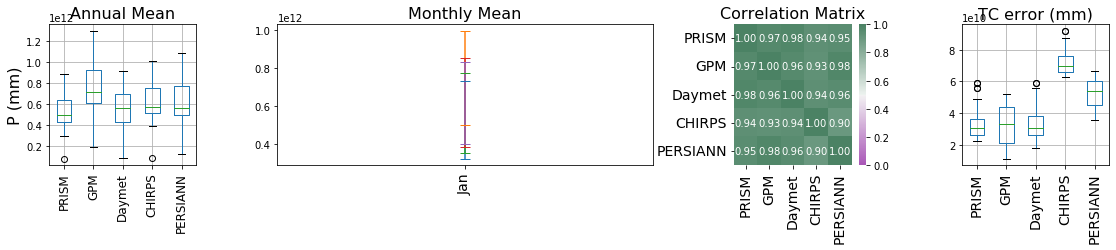

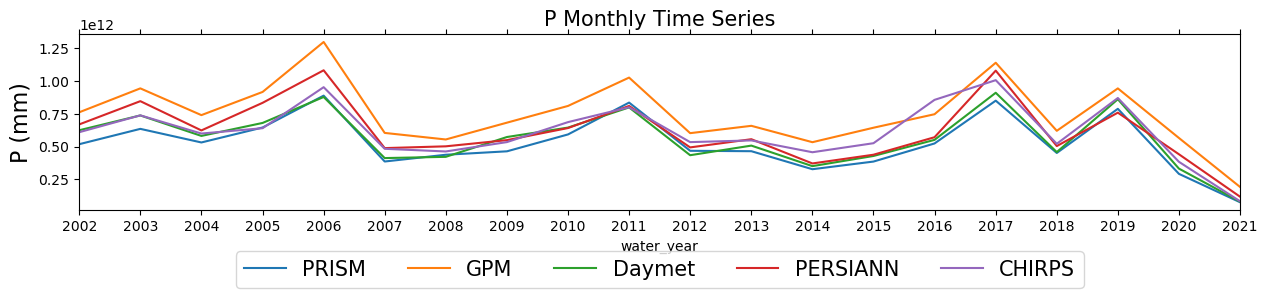

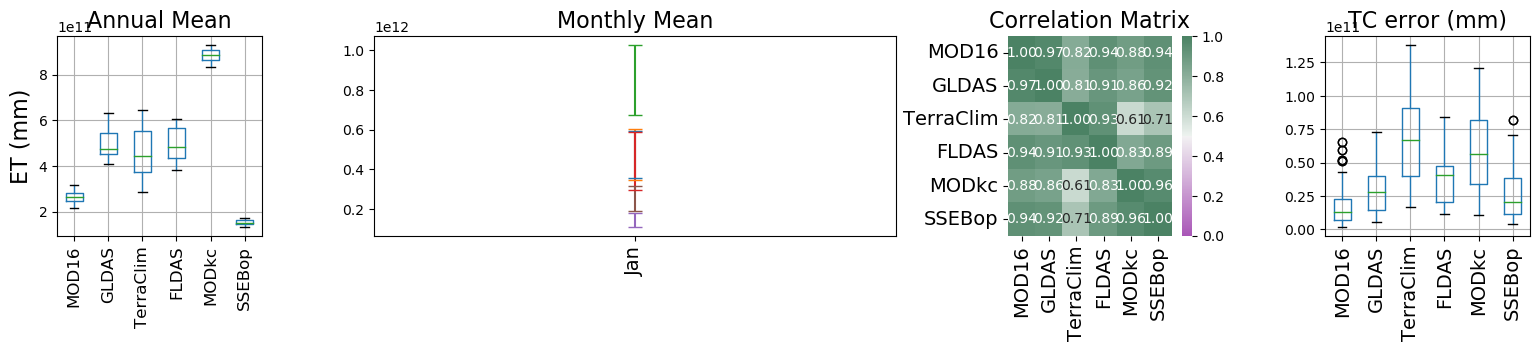

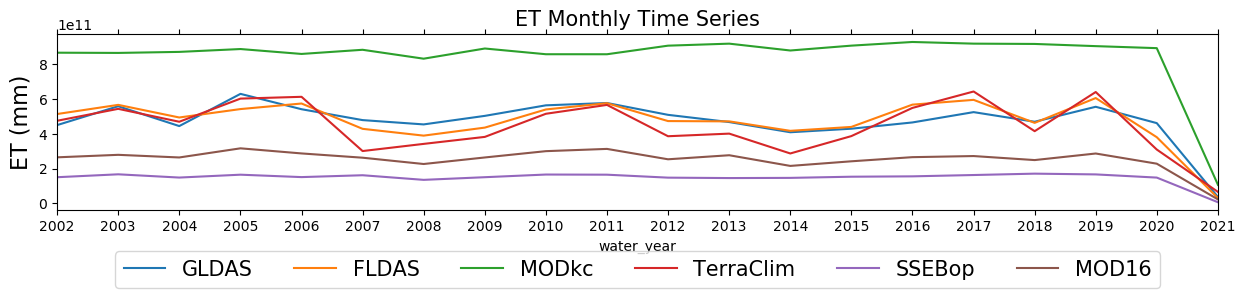

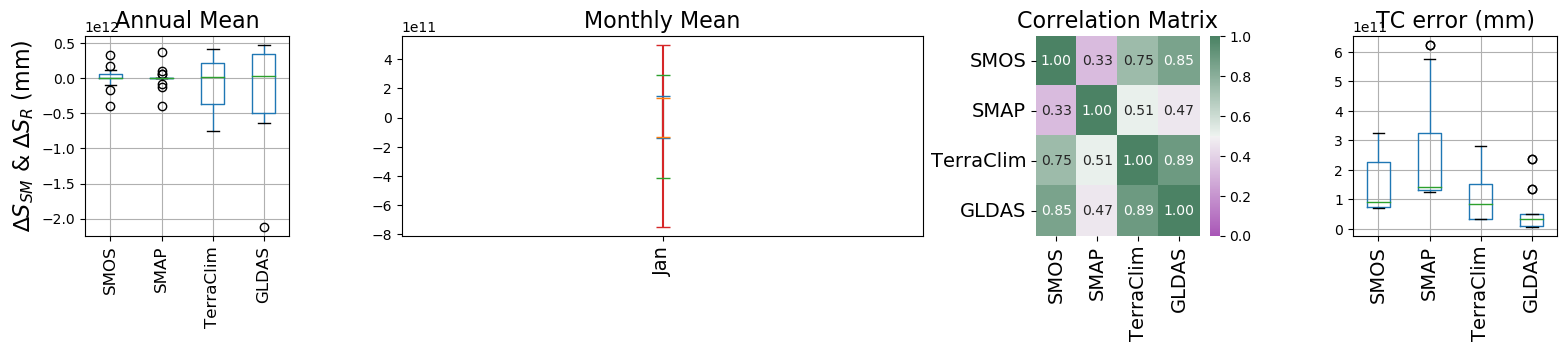

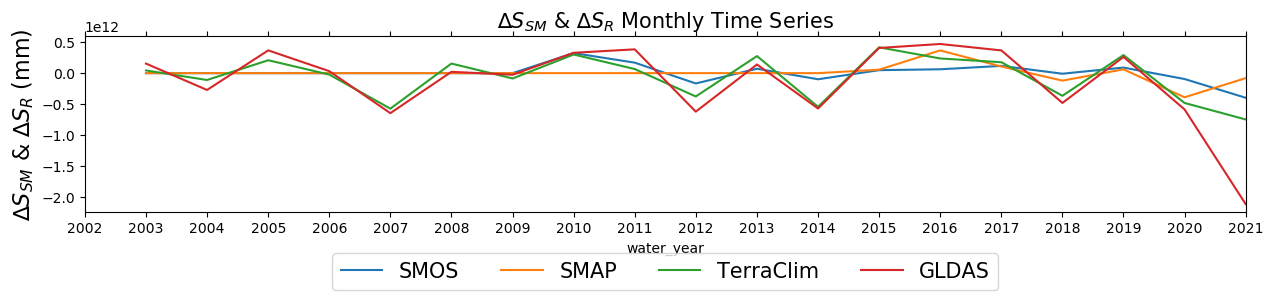

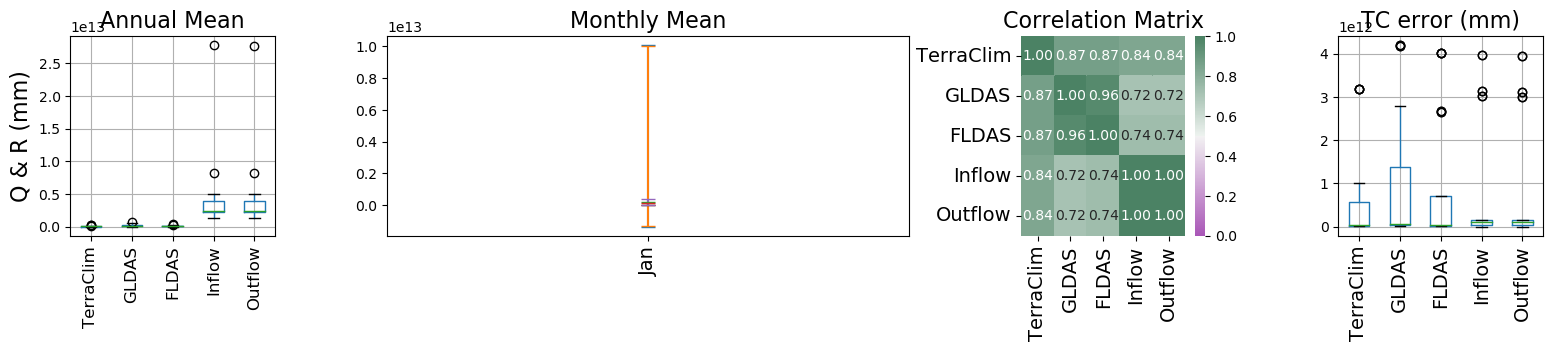

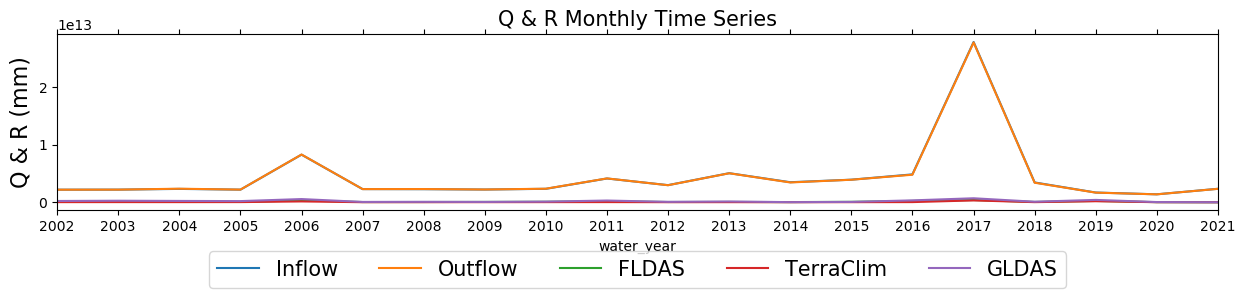

In [10]:
# plt.style.use("default")

area = gp.read_file("../shape/study_area/c2vsim_subregion5.shp")
# area.geometry.to_crs("EPSG:4326")
area_km2 = float(area.to_crs("EPSG:4326").area * 1e-6)


[p1, p2, p3, p4, p5] = make_plots(pdf/ area_km2 * 1e6, pcoldict, var = "P")
[et1, et2, et3, et4, et5] = make_plots(aetdf/ area_km2 * 1e6, aetcoldict, var = "ET")
[ds1, ds2, ds3, ds4, ds5] = make_plots(smdf.diff() / area_km2 * 1e6, smcoldict, var = "∆$S_{SM}$ & ∆$S_{R}$")
[qr1, qr2, qr3, qr4, qr5] = make_plots(rdf/ area_km2 * 1e6, rcoldict, var = "Q & R")

# Ensemble Balance

In [11]:
# CV full ensemble list 
plist = ["PRISM", "Daymet",'GPM','CHIRPS', "PERSIANN"]
etlist = ['TerraClim', "FLDAS", 'GLDAS','SSEBop','MODkc',"MOD16"]
smlist = ['TerraClim', "GLDAS",'SMOS','SMAP']
rlist = ['GLDAS', 'FLDAS','TerraClim']

combolist = list(itertools.product(*[plist,etlist,smlist,rlist]))
print("Full Ensemble has {} members".format(str(len(combolist))))

# CV LSM ensemble list 
plist_lsm = [ "PRISM", "Daymet"]
etlist_lsm = [ 'TerraClim', "FLDAS", 'GLDAS']
smlist_lsm = ['TerraClim', "GLDAS"]
rlist_lsm = ['GLDAS', 'FLDAS','TerraClim']

combolist_lsm = list(itertools.product(*[plist_lsm,etlist_lsm,smlist_lsm,rlist_lsm]))
print("LSM-based Ensemble has {} members".format(str(len(combolist_lsm))))

# CV RS ensemble list 
plist_rs = ['GPM','CHIRPS', "PERSIANN"]
etlist_rs = ['SSEBop','MODkc',"MOD16"]
smlist_rs = ['SMOS','SMAP','TerraClim']
rlist_rs = ['GLDAS','FLDAS','TerraClim']

combolist_rs = list(itertools.product(*[plist_rs,etlist_rs,smlist_rs,rlist_rs]))
print("RS based Ensemble has {} members".format(str(len(combolist_rs))))

Full Ensemble has 360 members
LSM-based Ensemble has 36 members
RS based Ensemble has 81 members


In [12]:
startidx = 8

pcoldict = {'p_prism':'PRISM', 
                'p_gpm':'GPM',  
                'p_dmet':'Daymet',
                'p_psn': "PERSIANN",
                'p_chirps': "CHIRPS"}
pdf = wbdf.loc[:, wbdf.columns.isin(pcoldict.keys())]
pdf = pdf.dropna(axis = 0, how = 'all')
pdf = pdf.rename(columns = pcoldict)


aetcoldict = {'aet_gldas':'GLDAS', 
                'aet_fldas':'FLDAS',  
                'MODkc':"MODkc",
                'aet_tc':'TerraClim',
                'ssebop': "SSEBop",
                'aet_modis': "MOD16"}
aetdf = wbdf.loc[:, wbdf.columns.isin(aetcoldict.keys())]
aetdf = aetdf.dropna(axis = 0, how = 'all')
aetdf = aetdf.rename(columns = aetcoldict)


petcoldict = {'pet_gldas':'GLDAS', 
                'pet_gmet':'Gridmet',  
                'pet_tc':'TerraClim',
                'pet_modis': "MOD16",
                'pet_nldas': "NLDAS"}
petdf = wbdf.loc[:, wbdf.columns.isin(petcoldict.keys())]
petdf = petdf.dropna(axis = 0, how = 'all')
petdf = petdf.rename(columns = petcoldict)


smcoldict = {'sm_smos':'SMOS', 
                'sm_smap':'SMAP',  
                'sm_tc':'TerraClim',
                'sm_gldas': "GLDAS",
                }

smdf = wbdf.loc[:, wbdf.columns.isin(smcoldict.keys())]
smdf = smdf.dropna(axis = 0, how = 'all')
smdf = smdf.rename(columns = smcoldict)


rcoldict = {'Inflow': 'Inflow',
            'Outflow': 'Outflow',
            'r_fldas':'FLDAS',  
            'r_tc':'TerraClim',
            'r_gldas': "GLDAS"}

rdf = wbdf.loc[:, wbdf.columns.isin(rcoldict.keys())]
rdf = rdf.dropna(axis = 0, how = 'all')
rdf = rdf.rename(columns = rcoldict)

In [22]:
# Run the ensembles
calibration_period = 5 # 5 years
sf = 1

dsens = []
for p,et,sm,r in combolist:
    ds = pdf[p] - aetdf[et] + rdf['Inflow'] - rdf['Outflow']*sf  - smdf[sm].diff()
    #dsens.append(np.cumsum(ds - np.mean(ds[:calibration_period])))
    dsens.append(ds)

dsens_lsm = []
for p,et,sm,r in combolist_lsm:
    ds_lsm = pdf[p] - aetdf[et]  + rdf['Inflow'] - rdf['Outflow']*sf  - smdf[sm].diff()
    #dsens_lsm.append(np.cumsum(ds_lsm - np.mean(ds_lsm[:calibration_period])))
    dsens_lsm.append(ds_lsm)

dsens_rs = []
for p,et,sm,r in combolist_rs:
    ds_rs = pdf[p] - aetdf[et] + rdf['Inflow'] - rdf['Outflow']*sf   - smdf[sm].diff()
    #dsens_rs.append(np.cumsum(ds_rs - np.mean(ds_rs[:calibration_period])))
    dsens_rs.append(ds_rs)
    
    
# Optimal ensemble - MODIS / ETkc mean, 
# Mean SNODAS / LRM swe
aetdf['rs_et_mean'] = np.nanmean([aetdf.loc[:,'MODkc'],aetdf.loc[:,'SSEBop'],aetdf.loc[:,'GLDAS'],
                                      aetdf.loc[:,'FLDAS'], aetdf.loc[:,'MOD16'],
                                      aetdf.loc[:,'TerraClim']], axis = 0)
aetdf['rs_et_mean_nokc'] = np.nanmean([aetdf.loc[:,'SSEBop'], aetdf.loc[:,'GLDAS'],
                                      aetdf.loc[:,'FLDAS'], aetdf.loc[:,'MOD16'],
                                      aetdf.loc[:,'TerraClim']], axis=0)
pdf['rs_precip_mean'] = np.nanmean([pdf.loc[:,'GPM'], pdf.loc[:,'PRISM'],
                                      pdf.loc[:,'Daymet'], pdf.loc[:,'PERSIANN'],
                                      pdf.loc[:,'CHIRPS']], axis=0)

smdf['rs_sm_mean'] = np.nanmean([smdf.loc[:,'TerraClim'],smdf.loc[:,'SMOS'],smdf.loc[:,'SMAP']], axis = 0)
rdf['r_mean'] = np.nanmean([rdf.loc[:,'TerraClim'],rdf.loc[:,'FLDAS'],rdf.loc[:,'GLDAS']], axis = 0)

#ds_opt_raw = pdf['GPM'] - aetdf['rs_et_mean'] + rdf['Inflow'] - rdf['Outflow']*sf - smdf['rs_sm_mean'].diff()
ds_opt_raw = pdf['rs_precip_mean'] - aetdf['rs_et_mean'] + rdf['Outflow'] - rdf['Outflow']*sf  - smdf['rs_sm_mean'].diff()

#ds_opt = np.cumsum(ds_opt_raw)
ds_opt = np.cumsum(ds_opt_raw - np.mean(ds_opt_raw[:calibration_period]))
print(np.mean(ds_opt_raw[:calibration_period]))
print(ds_opt_raw)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2002-01-01 to 2021-01-01
Freq: AS-JAN
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PRISM           20 non-null     float64
 1   GPM             20 non-null     float64
 2   Daymet          20 non-null     float64
 3   CHIRPS          20 non-null     float64
 4   PERSIANN        20 non-null     float64
 5   rs_precip_mean  20 non-null     float64
dtypes: float64(6)
memory usage: 1.1 KB
0.08332659045449191
water_year
2002-01-01         NaN
2003-01-01    0.078265
2004-01-01    0.059082
2005-01-01    0.043633
2006-01-01    0.152327
2007-01-01    0.071519
2008-01-01    0.007964
2009-01-01    0.043995
2010-01-01   -0.006786
2011-01-01    0.077520
2012-01-01    0.070021
2013-01-01   -0.004589
2014-01-01    0.066627
2015-01-01   -0.033679
2016-01-01   -0.017614
2017-01-01    0.100294
2018-01-01    0.066370
2019-01-01    0.049637
2020-01-01    0.0932

In [23]:
print(rdf['Inflow'])
print(rdf['Outflow'])

water_year
2002-01-01    0.633884
2003-01-01    0.636772
2004-01-01    0.673913
2005-01-01    0.635906
2006-01-01    2.399486
2007-01-01    0.664176
2008-01-01    0.659154
2009-01-01    0.641919
2010-01-01    0.678143
2011-01-01    1.198464
2012-01-01    0.863018
2013-01-01    1.465932
2014-01-01    1.010245
2015-01-01    1.138233
2016-01-01    1.405523
2017-01-01    8.075997
2018-01-01    0.999036
2019-01-01    0.490592
2020-01-01    0.401145
2021-01-01    0.680228
Freq: AS-JAN, Name: Inflow, dtype: float64
water_year
2002-01-01    0.633787
2003-01-01    0.637330
2004-01-01    0.683537
2005-01-01    0.638626
2006-01-01    2.405251
2007-01-01    0.663757
2008-01-01    0.666589
2009-01-01    0.643936
2010-01-01    0.683135
2011-01-01    1.202007
2012-01-01    0.859671
2013-01-01    1.461438
2014-01-01    0.998426
2015-01-01    1.135722
2016-01-01    1.388062
2017-01-01    8.051272
2018-01-01    0.985029
2019-01-01    0.486288
2020-01-01    0.400090
2021-01-01    0.677557
Freq: AS-JAN, N

In [24]:
# Take C2vsim relative to startdate of RS-based ensemble
c2vsim_subset = c2vsim.loc[wbdf.index[startidx]:,:]
offset = c2vsim.loc[wbdf.index[startidx]:,:].iloc[0].values
overlap = c2vsim_subset - offset

In [25]:
# Load butte data
b_sub_wb = pd.read_csv('../data/water_budget_spreadsheets/wyandotte_wy_budget.csv', skiprows=3, parse_dates=['WY'], 
                      thousands=',')
b_sub_wb_storage = b_sub_wb['Change in Groundwater Storage']*1.23348e-6

In [26]:
# Load well data
well_storage = pd.read_csv('../data/NewStorageEstimates_NEWINTERP_Wyandotte.csv')
print(well_storage['Saturation Storage (km3)'][::2])
#for i in range(2, len(well_storage),2):
#    well_storage['Saturation Storage (km3)'][i] = (well_storage['Saturation Storage (km3)'][i] 
#                                                   - well_storage['Saturation Storage (km3)'][i-2])



0     0.000000
2     0.000146
4     0.041730
6     0.067404
8     0.030638
10    0.015983
12   -0.078726
14   -0.021228
16    0.009287
18   -0.081378
20    0.002826
22   -0.087818
24   -0.093953
26   -0.069553
28    0.013466
30    0.026445
32   -0.008278
34   -0.044029
36   -0.065886
Name: Saturation Storage (km3), dtype: float64


In [27]:
print(b_sub_wb['WY'][34])
print(len(well_storage['Saturation Storage (km3)'][::2]))
print(well_storage['Saturation Storage (km3)'][::2])

2024-01-01 00:00:00
19
0     0.000000
2     0.000146
4     0.041730
6     0.067404
8     0.030638
10    0.015983
12   -0.078726
14   -0.021228
16    0.009287
18   -0.081378
20    0.002826
22   -0.087818
24   -0.093953
26   -0.069553
28    0.013466
30    0.026445
32   -0.008278
34   -0.044029
36   -0.065886
Name: Saturation Storage (km3), dtype: float64


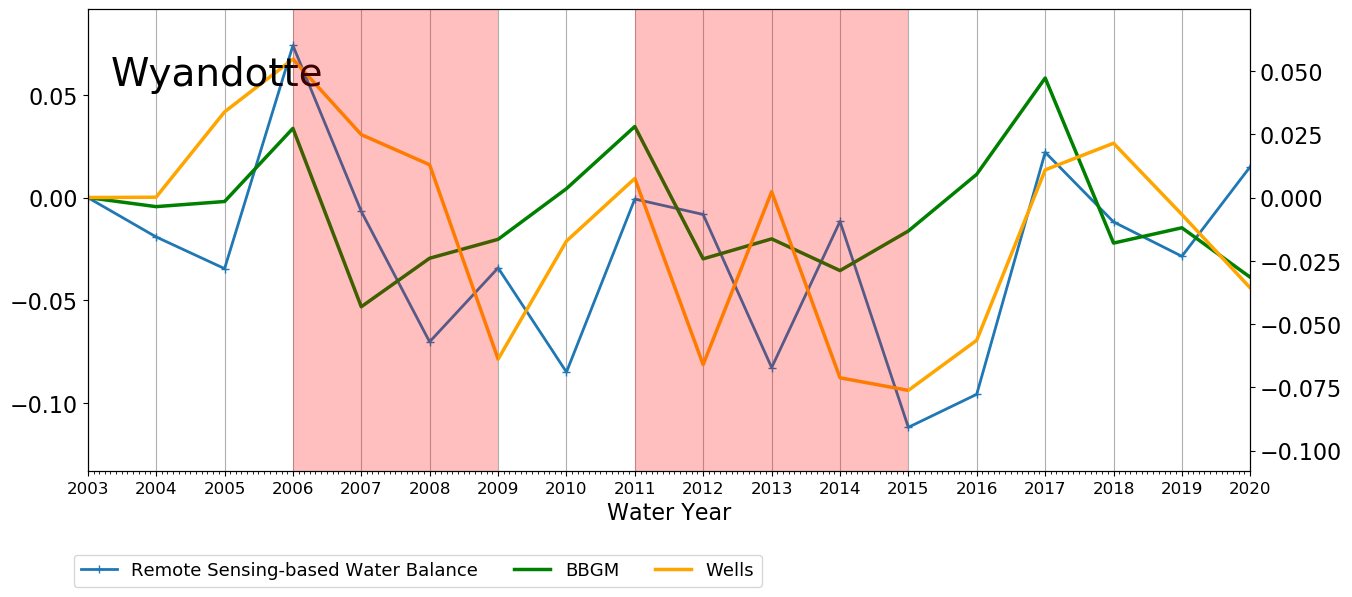

In [32]:
##### Main Plotting #####
plt.style.use('default')
fig, ax1 = plt.subplots(figsize = (15,6))
ax1.grid(axis = 'x')

# Plot optimal
ax1.plot(ds_opt_raw[:-1]-ds_opt_raw[1], label = 'Remote Sensing-based Water Balance', marker = "+",linewidth = 2)
# Plot BBGM
ax1.plot(b_sub_wb['WY'][13:32], b_sub_wb_storage[13:32]-b_sub_wb_storage[13], color='green', linewidth=2.5, label = 'BBGM')
# Plot Well Interpolation
ax1.plot(b_sub_wb['WY'][13:32], well_storage['Saturation Storage (km3)'][::2], color='orange', linewidth=2.5, label='Wells')
ax1.text(0.02, 0.9, 'Wyandotte',
        verticalalignment='top', horizontalalignment='left',
        transform=ax1.transAxes,
        color='black', fontsize=28)
##### Ensemble Plotting #####
# Plot all
#ax2.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensemble members')
#ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens)
#                                   -np.nanmean(np.vstack(dsens), axis=0)[1], axis = 0),color = 'black',linestyle = "--", alpha = 1, label = 'ADS ensemble mean' )
# Plot LSM
#ax2.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensemble members')
#ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0)
#         -np.nanmean(np.vstack(dsens_lsm), axis=0)[1],color ='purple', linestyle = "--", alpha = 1, label = 'GBLSM ensemble mean')

# Plot RS 
#ax2.plot(np.nanmean(np.vstack(dsens_rs)), alpha = 0.45, color = 'red', label = 'RS ensemble members')
#ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs)
#                                      -np.nanmean(np.vstack(dsens_rs), axis=0)[1], axis = 0),color ='red', linestyle = "--", alpha = 1, label = 'RS ensemble mean')

##### Plotting Components ######
#ax2.plot(b_sub_wb['WY'][14:32], X_ssa[0,:], label='PRS SSA', linewidth=2)
#ax2.plot(b_sub_wb['WY'][14:32], X_ssa[1,:], label='PRS SSA 1', linewidth=2)
#ax2.plot(ds_opt[:-1], label = 'PRS 2', marker = "+",linewidth = 2)
#ax2.plot(pdf['GPM'], label = 'GPM', linewidth = 2)
#ax2.plot(-1*aetdf['SSEBop'], label = 'SSEBop', linewidth = 2)
#ax2.plot(-1*smdf['rs_sm_mean'], label = 'Soil Moisture', linewidth=2)
#ax2.plot(rdf['Inflow'], label = 'Q Inflow', linewidth = 2)
#ax2.plot(-1*rdf['Outflow'], label = 'Q Outflow', linewidth = 2)
#ax2.plot(rdf['GW Inflow'], label = 'Q GW Inflow', linewidth = 2)
#ax2.plot(-1*rdf['GW Outflow'], label = 'Q GW Outflow', linewidth = 2)
#ax2.plot(rdf['Runoff Inflow'], label = 'Runoff Inflow', linewidth = 2)
#ax2.plot(-1*rdf['Runoff Outflow'], label = 'Runoff Outflow', linewidth = 2)
#ax2.plot(-1*smdf['rs_sm_mean'], label = 'Soil Moisture', linewidth=2)

##### Formatting ##### 
# second y axis for million acre feet
ax2 = ax1.twinx()
# set twin scale (convert km^3 to million acre-feet)
af = lambda km3: km3*810714./1000000
ymin, ymax = ax1.get_ylim()
# apply function and set transformed values to right axis limits
ax2.set_ylim((af(ymin),af(ymax)))
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
ax2.plot([],[])

# z order and grid settings
ax2.set_zorder(ax1.get_zorder()+1)
ax2.yaxis.grid(False)

# Align axes to 0
align_yaxis([ax1,ax2])
  
# Drought Periods
plt.axvspan(datetime.datetime(2006,1,1), datetime.datetime(2009,1,1), color='red', alpha=0.25, lw=0)
plt.axvspan(datetime.datetime(2011,1,1), datetime.datetime(2015,1,1), color='red', alpha=0.25, lw=0)

# Format Ticks
ax1.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax1.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax1.set_xlim(ds_opt.dropna().index[0], ds_opt.dropna().index[-2] )

# Title/Label/Tick/Legend Sizes
#ax1.set_title("Wyandotte $S_{gw}$ Anomaly", size = 25)
ax1.set_xlim(ds_opt.dropna().index[0], ds_opt.dropna().index[-2])
ax1.tick_params(axis='y', labelsize=16)
#ax1.set_ylabel('Sgw Anomaly ($km^3$)', fontsize=16) # Label km3
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xlabel('Water Year', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
#ax2.set_ylabel('Sgw Anomaly (million acre-feet)', fontsize=16)
ax1.legend(loc='lower left', ncol = 5, bbox_to_anchor=(-0.02, -0.27),
               fancybox=True,  prop={'size' : 13})  

In [33]:
compute_cov = np.array([ds_opt_raw[:-1]-ds_opt_raw[1], b_sub_wb_storage[13:32]-b_sub_wb_storage[13],
              well_storage['Saturation Storage (km3)'][::2]])
compute_cov[0,0] = 0
cov = np.corrcoef(compute_cov)
cov

array([[ 1.        , -0.48767886,  0.28259535],
       [-0.48767886,  1.        ,  0.2392142 ],
       [ 0.28259535,  0.2392142 ,  1.        ]])

In [29]:
PRS = np.array(ds_opt_raw[2:-1]-ds_opt_raw[1])
BBGM = np.array(b_sub_wb_storage[15:32])
wells = well_storage['Saturation Storage (km3)'][::2]

In [30]:
print(PRS)
print(BBGM)

[-0.01918271 -0.03463126  0.07406208 -0.00674522 -0.07030093 -0.03426928
 -0.0850501  -0.00074501 -0.00824336 -0.08285381 -0.01163779 -0.11194388
 -0.09587889  0.02202953 -0.01189423 -0.02862721  0.01501914]
[ 0.00194404  0.03758219 -0.04932291 -0.02569875 -0.01647002  0.00820909
  0.03848757 -0.02598899 -0.01625755 -0.03170631 -0.01242351  0.01518077
  0.06211362 -0.0183036  -0.0108524  -0.03496621  0.0337882 ]


In [31]:
PRS = np.array(ds_opt_raw[2:-1]-ds_opt_raw[1])
BBGM = np.array(b_sub_wb_storage[15:32])
print(len(PRS))
print(len(BBGM))
print(len(wells))
print("Butte Average vs. Butte:")
print("Average difference in time series in million acre-feet")
print(np.sqrt(np.mean((PRS-BBGM)**2))*810714/1000000)
print("Average difference in time series in km^3")
print(np.sqrt(np.mean((PRS-BBGM)**2)))
print("Average precent difference in time series")
print(np.mean(np.abs((PRS-BBGM)/BBGM)*100))
print("")

17
17
19
Butte Average vs. Butte:
Average difference in time series in million acre-feet
0.05821911339987287
Average difference in time series in km^3
0.07181214756359564
Average precent difference in time series
263.3853735887104



# Add shading and trendlines

In [20]:
def filt_df_dates(df,startdate,enddate):
    '''
    Filter the master df between desired dates, return the columns we are interested in  
    '''
    
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")

    df_mask = (df.index > start) & (df.index <= end)
    
    all_cv = df['cv_ds'][df_mask].values
    lsm_cv = df['cv_ds_lsm'][df_mask].values
    rs_cv = df['cv_ds_rs'][df_mask].values
    rs_cv_opt = df['cv_rs_opt'][df_mask].values
    
    all_cvws = df['cvws_ds'][df_mask].values
    lsm_cvws = df['cvws_ds_lsm'][df_mask].values
    rs_cvws = df['cvws_ds_rs'][df_mask].values
    rs_cvws_opt = df['cvws_rs_opt'][df_mask].values
    
    wells = df['GWS_km3_5MA'][df_mask].values
    c2vsim = df['Cum_GWS_km3'][df_mask].values
    grace = df['grace_mean'][df_mask].values
    
    dat = [all_cv, lsm_cv,rs_cv,rs_cv_opt,all_cvws,lsm_cvws, rs_cvws,rs_cvws_opt, c2vsim, wells, grace]
    
    dat_dict = dict(zip(['all_cv','LSM_cv', 'RS_cv','RS_cv_opt', 
                         'all_cvws', 'LSM_cvws','RS_cvws','RS_cvws_opt', 
                         'C2VSim', 'Wells', 'GRACE'], dat))
    
    return dat_dict

def fit_trend(array):
    '''
    Fit a linear trend to a 1d array, return the function and slope 
    '''
    z = np.polyfit(x=array, y=np.arange(0,len(array)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(array)
    x = np.arange(len(array))
    fit = np.polyfit(x, array, 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0])
        
    return fit_fn,annual_slope

def get_trendlines(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:fit_trend(v) for k,v in d.items()}
    
    yvals = {}
    for k,v in polyfits.items():
        fit = v[0]
        ynew = fit(xidx)
        yvals[k] = pd.DataFrame(ynew, index = pd.date_range(date1,date2,freq="M"))
        
    return yvals


def get_slopes(date1,date2, df):
    '''given a pd.series or pd.DataFrame, return the slope linear fit between two dates'''
    
    xidx = range(0,len(pd.date_range(date1, date2, freq = "M")))
    annual_t_idx = len(xidx) / 12
    d = filt_df_dates(df, date1, date2)
    polyfits = {k:round(fit_trend(v)[1]/annual_t_idx,1) for k,v in d.items()}
    
    return polyfits

In [21]:
# Compile the ensemble results  

ds_df = pd.DataFrame(np.nanmean(np.vstack(dsens), axis = 0), index = dsens[0].index)
ds_df.columns = ['ds_km3']
ds_df['ds_lsm'] = np.nanmean(np.vstack(dsens_lsm), axis = 0)
ds_df['ds_rs'] = np.nanmean(np.vstack(dsens_rs), axis = 0)
ds_df['ds_rs_opt'] = ds_opt

# Merge 
fin_dsdf_t1 = pd.merge(ds_df,overlap, left_index = True, right_index = True, how = 'outer')
fin_dsdf = pd.merge(fin_dsdf_t1,wells_ds.dropna(), left_index = True, right_index = True, how = 'outer').dropna()

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [22]:
# Select droughts / wet periods 
d1s,d1e = '2006-10-01', '2009-09-30'
d1t = get_trendlines(d1s,d1e,fin_dsdf)
d1s = get_slopes(d1s,d1e,fin_dsdf)

d2s,d2e = '2011-10-01', '2015-09-30'
d2t = get_trendlines(d2s,d2e,fin_dsdf)
d2s = get_slopes(d2s,d2e,fin_dsdf)

rc1s,rc1e = '2005-10-01', '2006-09-30'
rc1 = get_trendlines(rc1s,rc1e,fin_dsdf)
rc1s = get_slopes(rc1s,rc1e,fin_dsdf)

rc2s,rc2e = '2009-10-01', '2011-09-30'
rc2 = get_trendlines(rc2s,rc2e,fin_dsdf)
rc2s = get_slopes(rc2s,rc2e,fin_dsdf)

KeyError: 'cv_ds'

In [ ]:
# Drought 1 rate and net change 

for k,v in d1s.items():
    print(k)
    print(v)
    print(v * 3)

In [ ]:
# Drought 2 rate and net change 

for k,v in d2s.items():
    print(k)
    print(v)
    print(v * 4)

In [ ]:
# Plot
plt.style.use('default')
fig, ax1 = plt.subplots(figsize = (18,6))

# Transparent dummy plot for the mm axis 
ax1.plot(c2vsim.index, c2vsim['Cum_end_stor_km3']/ k_area_km2 * 1e6, color="darkorange",alpha = 0, linewidth = 1.5,label = "Wells") 

ax1.set_ylabel('ΔSgw (mm)')

ax1.grid(axis = 'x')

# Second axis for Km^3
ax2 = ax1.twinx()  

# Plot c2vsim
ax2.plot(overlap.index, overlap['Cum_end_stor_km3'], color="green", linewidth = 2.5,label = "C2VSim") 

# Plot wells
ax2.plot(wells_ds.index, wells_ds['Mean_of_sy_ss'], color="orange", linewidth = 2.5,label = "Wells") 

# Plot all
# ax2.plot(dsens_rs[0], alpha = 0.45, color = 'gray', label = 'ADS ensemble members')
# ax2.plot(dsens[0].index,np.nanmean(np.vstack(dsens), axis = 0),color = 'black',linestyle = "--", alpha = 1, label = 'ADS ensemble mean' )

# Plot LSM
# ax2.plot(np.nanmean(np.vstack(dsens_lsm)), alpha = 0.45, color = 'purple', label = 'GBLSM ensemble members')
# ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_lsm), axis = 0),color ='purple', linestyle = "--", alpha = 1, label = 'GBLSM ensemble mean')

# Plot RS 
# ax2.plot(np.nanmean(np.vstack(dsens_rs)), alpha = 0.45, color = 'red', label = 'RS ensemble members')
# ax2.plot(dsens_rs[0].index,np.nanmean(np.vstack(dsens_rs), axis = 0),color ='red', linestyle = "--", alpha = 1, label = 'RS ensemble mean')

# Plot optimal
ax2.plot(ds_opt, label = 'PRS', color = 'blue', marker = "+",linewidth = 2)

# Formatting 
ax2.set_ylabel('ΔSgw ($km^3$)') # Label km3
align_yaxis([ax1,ax2]) # Align the twin axes

# plot all ensembles 
# for d in dsens:
#     ax2.plot(d, alpha = 0.03, color = 'gray')
    
# plot all LSM ensembles 
# for d in dsens_lsm:
#     ax2.plot(d, alpha = 0.03, color = 'purple')
    
# plot all RS ensembles 
for d in dsens_rs:
    ax2.plot(d, alpha = 0.03, color = 'blue')

    
# Add calibration period label 
ax2.annotate('',verticalalignment="center",xy=(.0001, .35), xytext=(calibration_period/ len(ds_opt.dropna())*0.8,.35), xycoords='axes fraction',arrowprops=dict(arrowstyle='<->'),fontsize=20)
ax2.annotate('calibration period',xy=(.001, .37), xytext=(calibration_period/ len(ds_opt.dropna())/5,.37), xycoords='axes fraction')

# Format year / month ticks 
ax2.xaxis.set_major_locator(mdates.YearLocator())# Major ticks every year.
ax2.xaxis.set_minor_locator(mdates.MonthLocator()) # Minor ticks every month.
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))# Text in the x axis will be displayed in 'YYYY' format.
ax2.set_xlim(ds_opt.dropna().index[0], ds_opt.dropna().index[-1] )
ax2.set_ylim(np.nanmin(ds_opt.dropna())-10, np.nanmax(ds_opt.dropna())+3)


# Title
ax2.set_title("$\Delta S_{gw} = P - ET + Q_{net} + R - \Delta S_{sm}$", size = 25)

# Align axes
align_yaxis([ax1,ax2])

# add legend
plt.legend(loc='lower left', ncol = 5, bbox_to_anchor=(-0.02, -0.25),
               fancybox=True,  prop={'size': 13})    
    

# Plot trendlines
# ax2.plot(d1t['all_ds'], color = 'black', linewidth = 2.5) # trendline 
# ax2.plot(d2t['all_ds'], color = 'black', linewidth = 2.5) # trendline 

# ax2.plot(d1t['LSM_ds'], color = 'purple', linewidth = 2.5) # trendline 
# ax2.plot(d2t['LSM_ds'], color = 'purple', linewidth = 2.5) # trendline 

# ax2.plot(d1t['RS_ds'], color = 'red', linewidth = 2.5) # trendline 
# ax2.plot(d2t['RS_ds'], color = 'red', linewidth = 2.5) # trendline 

ax2.plot(d1t['RS_ds_opt'], color = 'blue', linewidth = 2.5) # trendline 
ax2.plot(d2t['RS_ds_opt'], color = 'blue', linewidth = 2.5) # trendline 

ax2.plot(d1t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 
ax2.plot(d2t['C2VSim'], color = 'green', linewidth = 2.5) # trendline 

ax2.plot(d1t['wells'], color = 'orange', linewidth = 2.5) # trendline 
ax2.plot(d2t['wells'], color = 'orange', linewidth = 2.5) # trendline 


# Shade droughts 
ax2.axvline(d1t['RS_ds'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax2.axvline(d1t['RS_ds'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

ax2.axvline(d2t['RS_ds'].index[0],linestyle = '--', alpha=0.7, color = 'black')
ax2.axvline(d2t['RS_ds'].index[-1],linestyle = '--', alpha=0.7, color = 'black')

# Annotate slope of trendlines 
# Drought 1
ax2.annotate("2006 - 2009 drought", xy=(0.29, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13, bbox=dict(fc="white",lw = 0, ec = None))

# ax2.annotate("{} $km^3$/year [ADS]".format(d1s['all_ds']),xy=(0.29, 0.26),
#              color = "black", xycoords="axes fraction", size = 13)
# ax2.annotate("{} $km^3$/year [GBLSM]".format(d1s['LSM_ds']),xy=(0.29, 0.21),
#              color = "purple", xycoords="axes fraction", size = 13)
# ax2.annotate("{} $km^3$/year [ARS]".format(d1s['RS_ds']),xy=(0.29, 0.16),
#              color = "red", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [PRS]".format(d1s['RS_ds_opt']),xy=(0.29, 0.11),
             color = "blue", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [C2VSIM]".format(d1s['C2VSim']),xy=(0.29, 0.05), 
             color = 'green',xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [Wells]".format(d1s['wells']),xy=(0.29, 0.01), 
             color = 'orange',xycoords="axes fraction", size = 13)

# Drought 2
ax2.annotate("2011 - 2015 drought", xy=(0.58, 0.94), 
             color = 'black',xycoords="axes fraction", size = 13,  bbox=dict(fc="white",lw = 0, ec = None))

# ax2.annotate("{} $km^3$/year [ADS]".format(d2s['all_ds']),xy=(0.58, 0.26),
#              color = "black", xycoords="axes fraction", size = 13)
# ax2.annotate("{} $km^3$/year [GBLSM]".format(d2s['LSM_ds']),xy=(0.58, 0.21),
#              color = "purple", xycoords="axes fraction", size = 13)
# ax2.annotate("{} $km^3$/year [ARS]".format(d2s['RS_ds']),xy=(0.58, 0.16),
#              color = "red", xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [PRS]".format(d2s['RS_ds_opt']),xy=(0.58, 0.11),
             color = "blue", xycoords="axes fraction", size = 14)
ax2.annotate("{} $km^3$/year [C2VSIM]".format(d2s['C2VSim']),xy=(0.58, 0.06), 
             color = 'green',xycoords="axes fraction", size = 13)
ax2.annotate("{} $km^3$/year [Wells]".format(d2s['wells']),xy=(0.58, 0.01), 
             color = 'orange',xycoords="axes fraction", size = 13)

plt.show()
